## Notebook Overview: Weather Analysis

This notebook loads and visualizes weather data from a GRIB file, focusing on 2-meter air temperature fields. The GRIB file contains regional atmospheric model output, and temperature values are converted from Kelvin to Celsius.

The code extracts time series and spatial slices from this data to investigate weather conditions around Stagecoach Reservoir. While the GRIB data is used for spatial context, ground-truth weather observations was used as the primary dataset within our analysis. The **C3SKI weather station operated by UCSD**, provides calibrated meteorological measurements 7.2 km from the reservoir. This notebook complements C3SKI data by offering broader regional trends and visual context for local weather conditions.

In [ ]:
# . . . . . Importing Packages

import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta

Ignoring index file '/Users/mariannamarquardt/Desktop/field_camp/954dfd6d294a4efe8363cac439bf4cd0.grib.5b7b6.idx' incompatible with GRIB file
skipping variable: paramId==140230 shortName='mwd'
Traceback (most recent call last):
  File "/opt/miniconda3/envs/dsci/lib/python3.9/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/miniconda3/envs/dsci/lib/python3.9/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='latitude' value=Variable(dimensions=('latitude',), data=array([41.  , 40.75, 40.5 , 40.25, 40.  ])) new_value=Variable(dimensions=('latitude',), data=array([41. , 40.5, 40. ]))
skipping variable: paramId==140232 shortName='mwp'
Traceback (most recent call last):
  File "/opt/miniconda3/envs/dsci/lib/python3.9/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(va

GRIB CRS (should be lat/lon): None
TIFF CRS: EPSG:4326


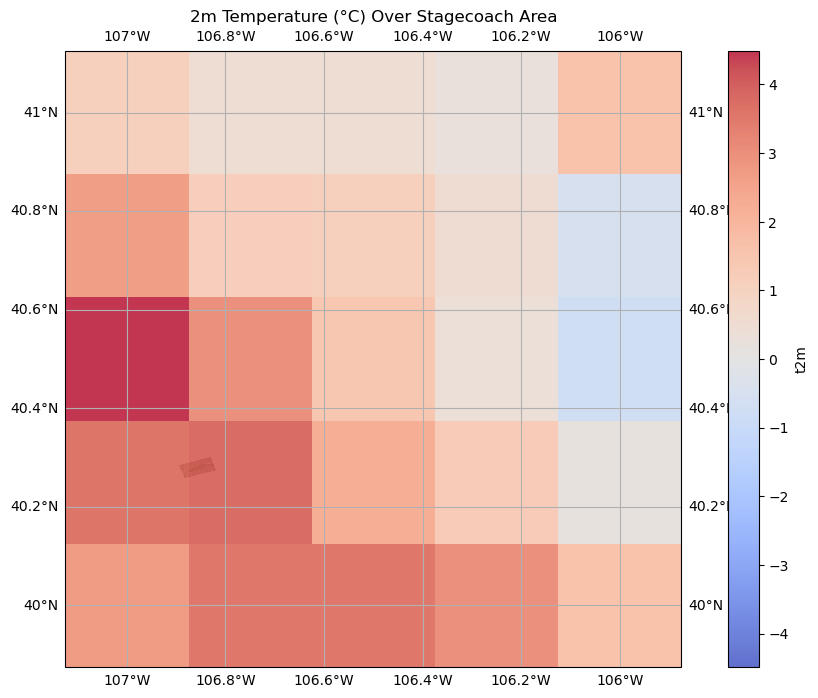

In [ ]:
# Load GRIB weather data
grib_path = "/Users/mariannamarquardt/Desktop/field_camp/954dfd6d294a4efe8363cac439bf4cd0.grib"
ds = xr.open_dataset(grib_path, engine="cfgrib")
t2m = ds["t2m"] - 273.15  # Convert Kelvin to °C

# Load georeferenced TIFF (Stagecoach map)
tiff_path = "/Users/mariannamarquardt/Desktop/field_camp/stagecoach.tif"
stagecoach_tiff = rioxarray.open_rasterio(tiff_path)

print("GRIB CRS (should be lat/lon):", ds.rio.crs)  # Should be EPSG:4326 (WGS84)
print("TIFF CRS:", stagecoach_tiff.rio.crs)

# Reproject TIFF if needed (e.g., if not in WGS84)
if stagecoach_tiff.rio.crs != "EPSG:4326":
    stagecoach_tiff = stagecoach_tiff.rio.reproject("EPSG:4326")

# Get GRIB bounds
grib_bounds = {
    "minx": ds.longitude.min().values,
    "maxx": ds.longitude.max().values,
    "miny": ds.latitude.min().values,
    "maxy": ds.latitude.max().values
}

# Clip TIFF to match GRIB area
stagecoach_clipped = stagecoach_tiff.rio.clip_box(**grib_bounds)

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot Stagecoach TIFF (as basemap)
stagecoach_clipped.plot.imshow(ax=ax, alpha=0.5, cmap="gray")  # Semi-transparent

# Overlay temperature data
t2m.isel(time=0).plot(ax=ax, cmap="coolwarm", add_colorbar=True, alpha=0.8)

# Add map features
ax.coastlines(color="black", linewidth=0.5)
ax.gridlines(draw_labels=True)
ax.set_title("2m Temperature (°C) Over Stagecoach Area")

plt.show()

Ignoring index file '/Users/mariannamarquardt/Desktop/field_camp/954dfd6d294a4efe8363cac439bf4cd0.grib.5b7b6.idx' incompatible with GRIB file
skipping variable: paramId==140230 shortName='mwd'
Traceback (most recent call last):
  File "/opt/miniconda3/envs/dsci/lib/python3.9/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/miniconda3/envs/dsci/lib/python3.9/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='latitude' value=Variable(dimensions=('latitude',), data=array([41.  , 40.75, 40.5 , 40.25, 40.  ])) new_value=Variable(dimensions=('latitude',), data=array([41. , 40.5, 40. ]))
skipping variable: paramId==140232 shortName='mwp'
Traceback (most recent call last):
  File "/opt/miniconda3/envs/dsci/lib/python3.9/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(va

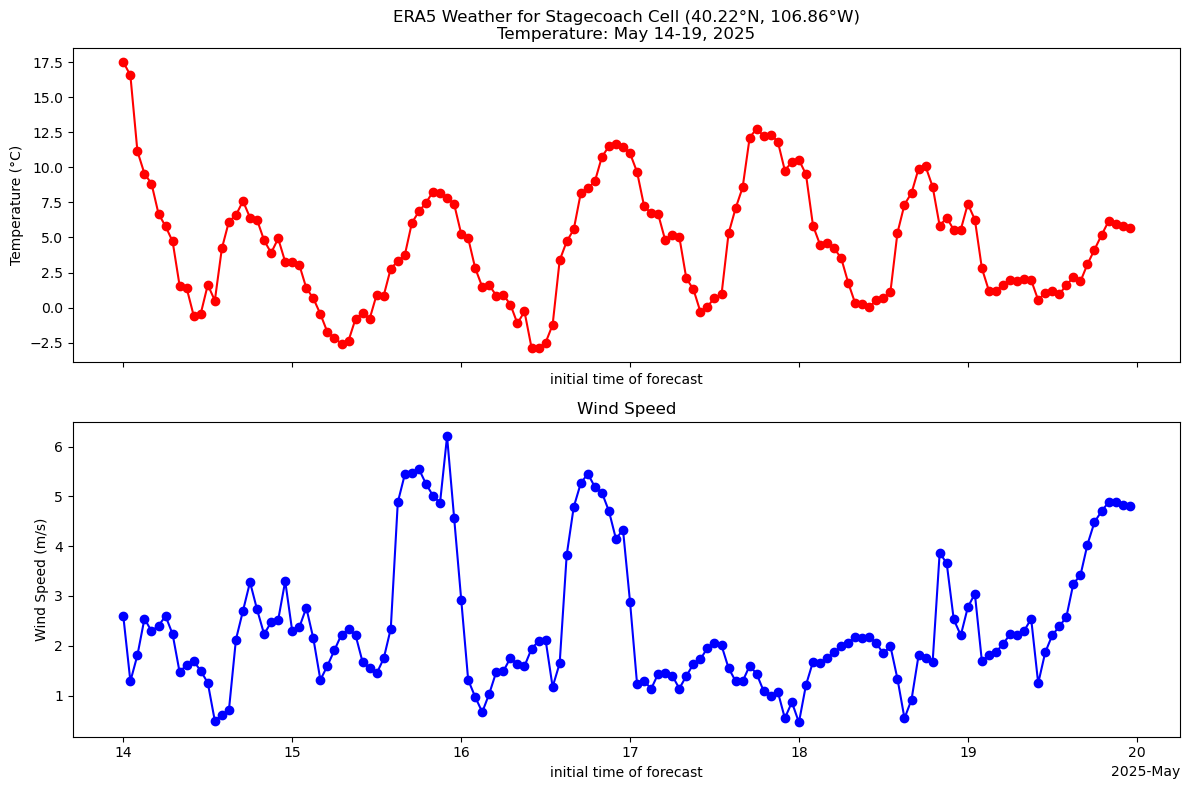


Temperature Statistics (May 14-19, 2025):
Max: 17.5°C
Min: -2.9°C
Mean: 4.5°C

Wind Speed Statistics:
Max: 6.2 m/s
Mean: 2.4 m/s


In [ ]:
# --- Re-Load Data ---
ds = xr.open_dataset("/Users/mariannamarquardt/Desktop/field_camp/954dfd6d294a4efe8363cac439bf4cd0.grib",
                    engine="cfgrib")

# Convert temperature to Celsius
t2m = ds["t2m"] - 273.15

# --- Filter by Date ---
date_range = slice("2025-05-14", "2025-05-19")
ds_filtered = ds.sel(time=date_range)
t2m_filtered = t2m.sel(time=date_range)

# --- Find Nearest Grid Cell to Weather Station ---
station_lat, station_lon = 40.22171, -106.86308
station_data = ds_filtered.sel(
    latitude=station_lat,
    longitude=station_lon,
    method="nearest"
)

# --- Extract Time Series ---
# Temperature
temp_series = t2m_filtered.sel(
    latitude=station_lat,
    longitude=station_lon,
    method="nearest"
)

# Wind Speed (assuming u10/v10 components exist)
if 'u10' in ds and 'v10' in ds:
    u10 = ds_filtered['u10'].sel(latitude=station_lat, longitude=station_lon, method="nearest")
    v10 = ds_filtered['v10'].sel(latitude=station_lat, longitude=station_lon, method="nearest")
    wind_speed = (u10**2 + v10**2)**0.5  # Calculate wind magnitude
else:
    print("Wind components (u10/v10) not found in dataset")

# --- Plot Time Series ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Temperature Plot
temp_series.plot(ax=ax1, color='red', marker='o')
ax1.set_ylabel("Temperature (°C)")
ax1.set_title(f"ERA5 Weather for Stagecoach Cell (40.22°N, 106.86°W)\nTemperature: May 14-19, 2025")

# Wind Speed Plot (if available)
if 'wind_speed' in locals():
    wind_speed.plot(ax=ax2, color='blue', marker='o')
    ax2.set_ylabel("Wind Speed (m/s)")
    ax2.set_title("Wind Speed")
else:
    ax2.set_visible(False)  # Hide if no wind data

plt.tight_layout()
plt.show()

# --- Print Summary Statistics ---
print("\nTemperature Statistics (May 14-19, 2025):")
print(f"Max: {temp_series.max().values:.1f}°C")
print(f"Min: {temp_series.min().values:.1f}°C")
print(f"Mean: {temp_series.mean().values:.1f}°C")

if 'wind_speed' in locals():
    print("\nWind Speed Statistics:")
    print(f"Max: {wind_speed.max().values:.1f} m/s")
    print(f"Mean: {wind_speed.mean().values:.1f} m/s")

/var/folders/r_/ycpl10_12p57968k690gts8r0000gn/T/ipykernel_35942/1229241236.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['air_temp_set_1'] = pd.to_numeric(filtered_df['air_temp_set_1'], errors='coerce')
/var/folders/r_/ycpl10_12p57968k690gts8r0000gn/T/ipykernel_35942/1229241236.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['wind_speed_set_1'] = pd.to_numeric(filtered_df['wind_speed_set_1'], errors='coerce')
Ignoring index file '/Users/mariannamarquardt/Desktop/field_ca

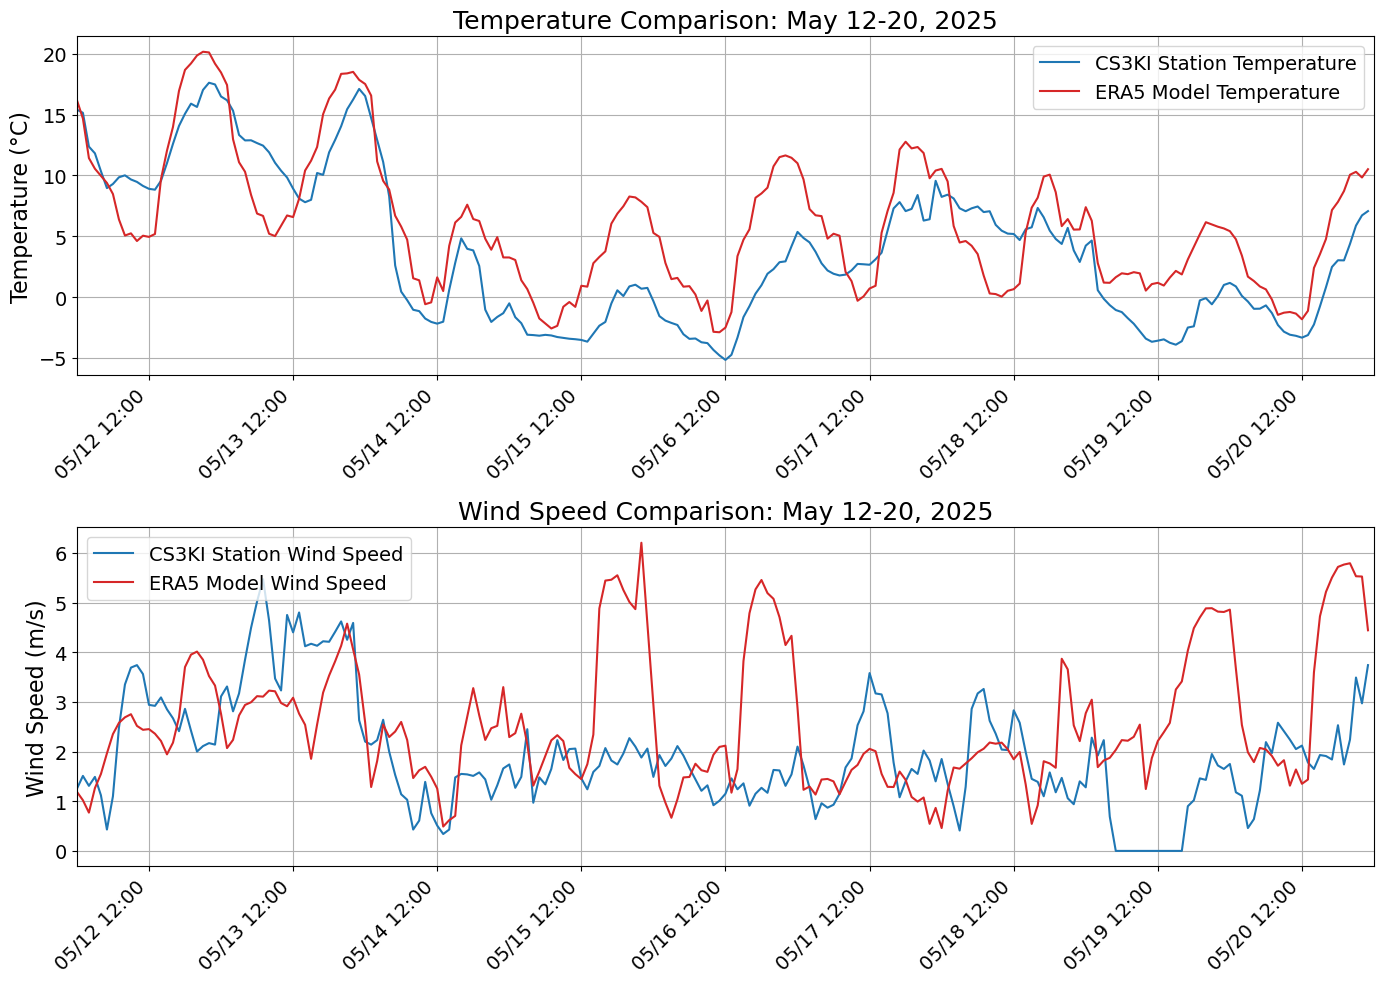


Station data date range: 2025-05-12 00:00:00 to 2025-05-20 23:00:00
ERA5 data date range: 2025-05-12 00:00:00 to 2025-05-20 23:00:00


In [ ]:
# --- Set global font sizes ---
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

# --- Load and process CS3KI station data ---
def load_station_data():
    file_path = '/Users/mariannamarquardt/Desktop/C3SKI.2025-05-28.csv'
    df = pd.read_csv(file_path, skiprows=10)
    df = df.drop(index=0).reset_index(drop=True)

    # Convert 'Date_Time' to datetime
    df['Date_Time'] = pd.to_datetime(df['Date_Time'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)
    df['Date_Time'] = df['Date_Time'].dt.tz_convert(None)

    # Filter for May 12-20, 2025
    start_date = pd.to_datetime('2025-05-12')
    end_date = pd.to_datetime('2025-05-20 23:59:59')
    filtered_df = df[(df['Date_Time'] >= start_date) & (df['Date_Time'] <= end_date)]

    # Ensure numeric data
    filtered_df['air_temp_set_1'] = pd.to_numeric(filtered_df['air_temp_set_1'], errors='coerce')
    filtered_df['wind_speed_set_1'] = pd.to_numeric(filtered_df['wind_speed_set_1'], errors='coerce')
    filtered_df = filtered_df.dropna(subset=['air_temp_set_1', 'wind_speed_set_1'])

    return filtered_df

# --- Load and process ERA5 model data ---
def load_era5_data():
    ds = xr.open_dataset("/Users/mariannamarquardt/Desktop/field_camp/954dfd6d294a4efe8363cac439bf4cd0.grib",
                        engine="cfgrib")

    # Convert to Celsius
    t2m = ds["t2m"] - 273.15

    # Filter by date
    date_range = slice("2025-05-12", "2025-05-20")
    ds_filtered = ds.sel(time=date_range)
    t2m_filtered = t2m.sel(time=date_range)

    # Find nearest grid cell to weather station
    station_lat, station_lon = 40.22171, -106.86308
    temp_series = t2m_filtered.sel(
        latitude=station_lat,
        longitude=station_lon,
        method="nearest"
    )

    # Calculate wind speed
    u10 = ds_filtered['u10'].sel(latitude=station_lat, longitude=station_lon, method="nearest")
    v10 = ds_filtered['v10'].sel(latitude=station_lat, longitude=station_lon, method="nearest")
    wind_speed = (u10**2 + v10**2)**0.5

    # Convert to pandas DataFrame for easier plotting
    era5_df = pd.DataFrame({
        'Date_Time': temp_series.time.values,
        'air_temp_set_1': temp_series.values,
        'wind_speed_set_1': wind_speed.values
    })

    return era5_df

# --- Load both datasets ---
station_df = load_station_data()
era5_df = load_era5_data()

# --- Create plots ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Temperature plot - CS3KI (blue), ERA5 (red)
ax1.plot(station_df['Date_Time'], station_df['air_temp_set_1'],
         color='tab:blue', label='CS3KI Station Temperature')
ax1.plot(era5_df['Date_Time'], era5_df['air_temp_set_1'],
         color='tab:red', label='ERA5 Model Temperature')  # Removed linestyle='--'
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Temperature Comparison: May 12-20, 2025')
ax1.legend()
ax1.grid(True)

# Wind speed plot - CS3KI (blue), ERA5 (red)
ax2.plot(station_df['Date_Time'], station_df['wind_speed_set_1'],
         color='tab:blue', label='CS3KI Station Wind Speed')
ax2.plot(era5_df['Date_Time'], era5_df['wind_speed_set_1'],
         color='tab:red', label='ERA5 Model Wind Speed')  # Removed linestyle='--'
ax2.set_ylabel('Wind Speed (m/s)')
ax2.set_title('Wind Speed Comparison: May 12-20, 2025')
ax2.legend()
ax2.grid(True)

# Create noon timestamps for tick marks
start_date = datetime(2025, 5, 12)
end_date = datetime(2025, 5, 20)
noon_ticks = [start_date + timedelta(days=i) + timedelta(hours=12) for i in range((end_date - start_date).days + 1)]

# Format x-axis with ticks at noon each day
for ax in [ax1, ax2]:
    ax.set_xticks(noon_ticks)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust x-axis limits to show full date range
for ax in [ax1, ax2]:
    ax.set_xlim([pd.to_datetime('2025-05-12'), pd.to_datetime('2025-05-21')])

plt.tight_layout()
plt.show()

# Print data availability
print("\nStation data date range:", station_df['Date_Time'].min(), "to", station_df['Date_Time'].max())
print("ERA5 data date range:", era5_df['Date_Time'].min(), "to", era5_df['Date_Time'].max())

/var/folders/r_/ycpl10_12p57968k690gts8r0000gn/T/ipykernel_35942/2964107738.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['wind_6h']  = df['wind_speed_set_1'].rolling('6H').mean()
/var/folders/r_/ycpl10_12p57968k690gts8r0000gn/T/ipykernel_35942/2964107738.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['wind_12h'] = df['wind_speed_set_1'].rolling('12H').mean()
/var/folders/r_/ycpl10_12p57968k690gts8r0000gn/T/ipykernel_35942/2964107738.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['wind_24h'] = df['wind_speed_set_1'].rolling('24H').mean()


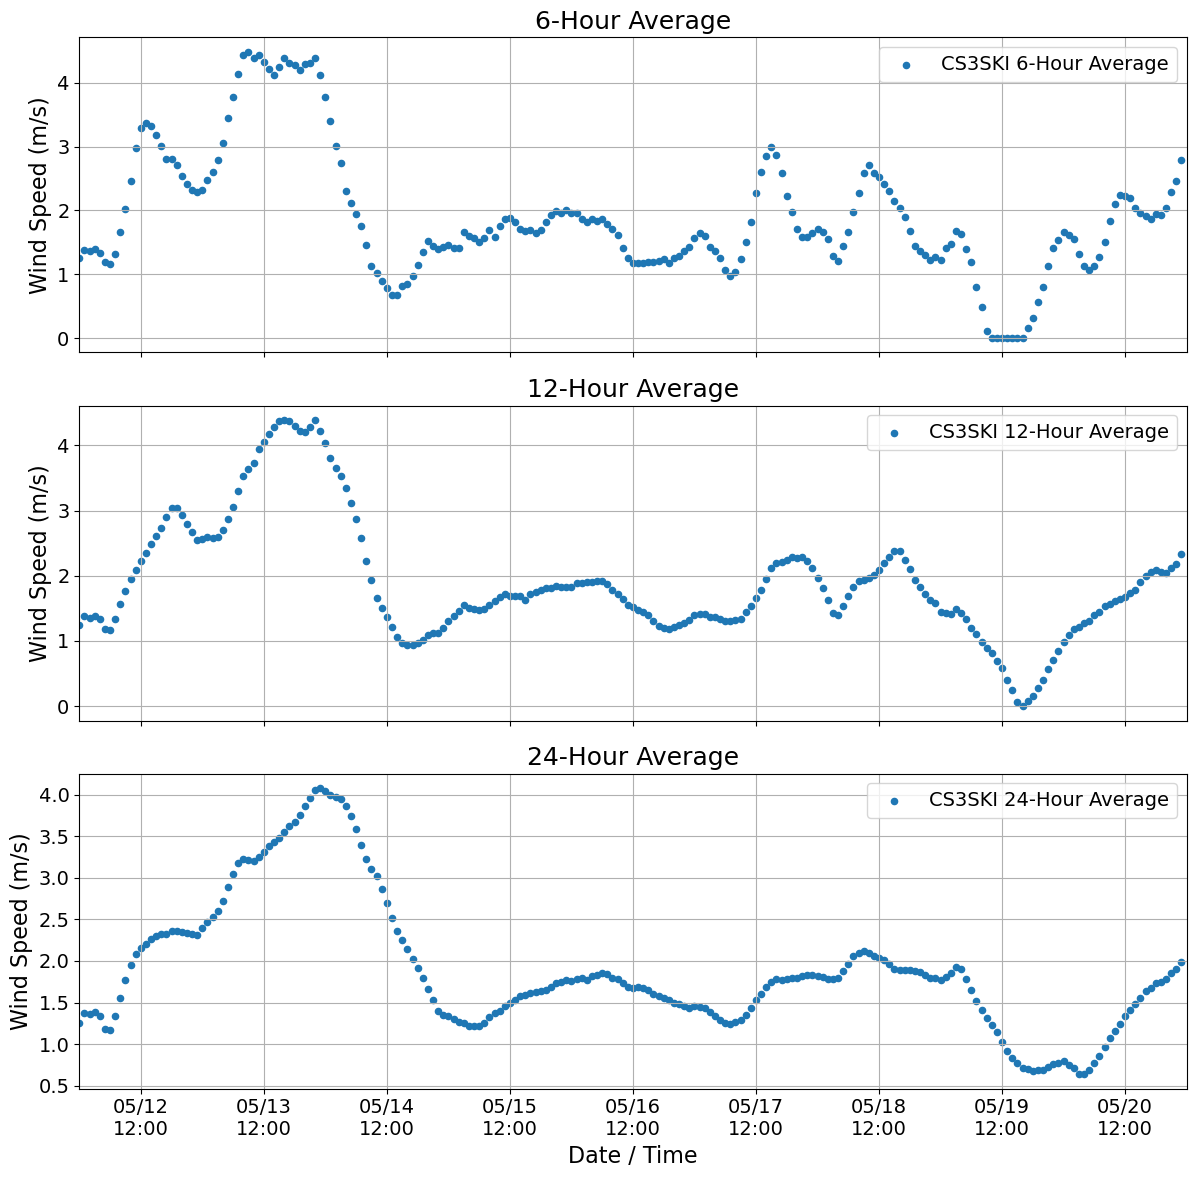

CS3KI station data range: 2025-05-12 00:00:00 to 2025-05-20 23:00:00


In [ ]:

# --- Set global font sizes ---
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

# --- Load and process CS3KI station data ---
def load_station_data():
    file_path = '/Users/mariannamarquardt/Desktop/C3SKI.2025-05-28.csv'
    df = pd.read_csv(file_path, skiprows=10).drop(index=0).reset_index(drop=True)
    df['Date_Time'] = (
        pd.to_datetime(df['Date_Time'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)
          .dt.tz_convert(None)
    )
    start_date = pd.to_datetime('2025-05-12')
    end_date   = pd.to_datetime('2025-05-20 23:59:59')
    df = df[(df['Date_Time'] >= start_date) & (df['Date_Time'] <= end_date)]
    df['air_temp_set_1']   = pd.to_numeric(df['air_temp_set_1'],   errors='coerce')
    df['wind_speed_set_1'] = pd.to_numeric(df['wind_speed_set_1'], errors='coerce')
    return df.dropna(subset=['air_temp_set_1','wind_speed_set_1']).reset_index(drop=True)

# --- Add rolling averages ---
def add_rolling_averages(df):
    df = df.copy().set_index('Date_Time')
    df['wind_6h']  = df['wind_speed_set_1'].rolling('6H').mean()
    df['wind_12h'] = df['wind_speed_set_1'].rolling('12H').mean()
    df['wind_24h'] = df['wind_speed_set_1'].rolling('24H').mean()
    return df.reset_index()

# --- Load CS3KI dataset and apply rolling averages ---
station_df = add_rolling_averages(load_station_data())

# --- Prepare common styling for x-axis ---
start_date = datetime(2025, 5, 12)
end_date   = datetime(2025, 5, 20)
noon_ticks = [start_date + timedelta(days=i, hours=12)
              for i in range((end_date - start_date).days + 1)]
date_fmt = mdates.DateFormatter('%m/%d\n%H:%M')

# --- Plot rolling averages as subfigures (CS3KI only) ---
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

windows = [('wind_6h',  '6-Hour Average'),
           ('wind_12h', '12-Hour Average'),
           ('wind_24h', '24-Hour Average')]

for ax, (col, title) in zip(axes, windows):
    ax.scatter(station_df['Date_Time'], station_df[col],
               color='tab:blue', s=20, label=f'CS3SKI {title}')
    ax.set_ylabel('Wind Speed (m/s)')
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.grid(True)
    ax.set_xticks(noon_ticks)
    ax.xaxis.set_major_formatter(date_fmt)

axes[-1].set_xlim(pd.to_datetime('2025-05-12'), pd.to_datetime('2025-05-21'))
plt.xlabel('Date / Time')
plt.tight_layout()
plt.show()

# --- Optional: print data ranges ---
print("CS3KI station data range:", station_df['Date_Time'].min(), "to", station_df['Date_Time'].max())


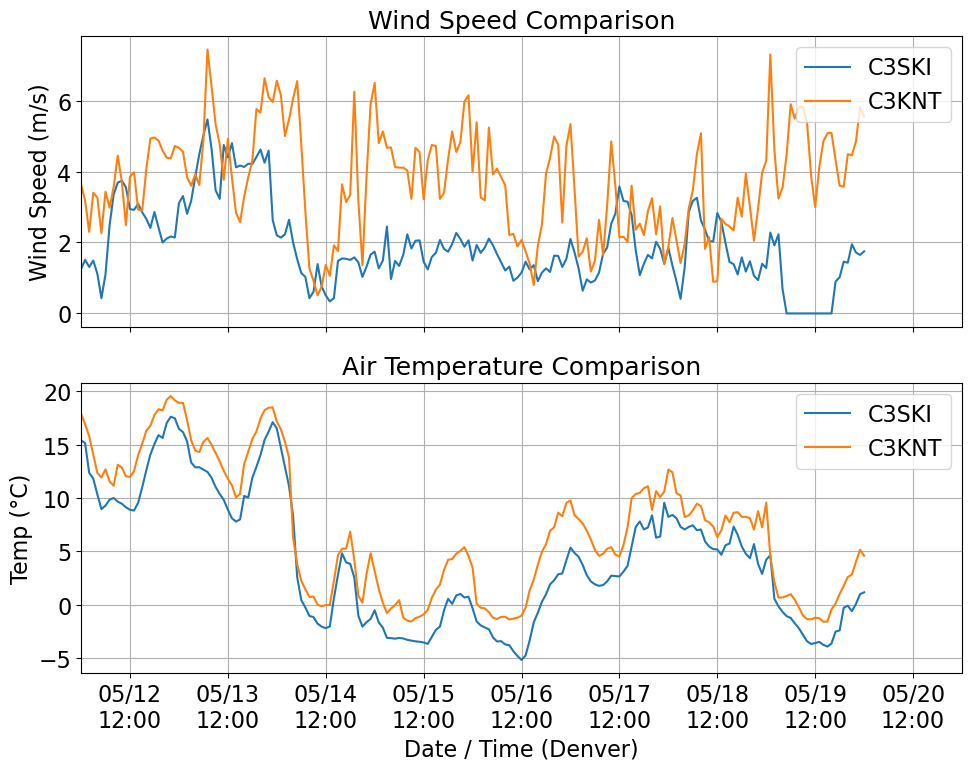

C3SKI data range: 2025-05-12 00:00:00 to 2025-05-20 00:00:00
C3KNT data range: 2025-05-12 00:00:00 to 2025-05-20 00:00:00


In [ ]:
# --- Updating font sizes ---
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

# --- Function to load and process station data ---
def load_station_data(file_path, start_date, end_date):
    df = pd.read_csv(file_path, skiprows=10).drop(index=0).reset_index(drop=True)
    df['Date_Time'] = (
        pd.to_datetime(df['Date_Time'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)
          .dt.tz_convert(None)
    )
    df = df[(df['Date_Time'] >= start_date) & (df['Date_Time'] <= end_date)]
    df['wind_speed_set_1'] = pd.to_numeric(df['wind_speed_set_1'], errors='coerce')
    df['air_temp_set_1'] = pd.to_numeric(df['air_temp_set_1'], errors='coerce')
    return df.dropna(subset=['wind_speed_set_1', 'air_temp_set_1']).reset_index(drop=True)

# --- Define date range ---
start_date = datetime(2025, 5, 12)
end_date   = datetime(2025, 5, 20)

# --- Loading datasets ---
ski_path = '/Users/mariannamarquardt/Desktop/C3SKI.2025-05-28.csv'
knt_path = '/Users/mariannamarquardt/Desktop/C3KNT.2025-06-02.csv'

ski_df = load_station_data(ski_path, start_date, end_date)
knt_df = load_station_data(knt_path, start_date, end_date)

# --- Create subplots: wind speed and air temp ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- Wind speed subplot ---
ax1.plot(ski_df['Date_Time'], ski_df['wind_speed_set_1'], label='C3SKI', color='tab:blue')
ax1.plot(knt_df['Date_Time'], knt_df['wind_speed_set_1'], label='C3KNT', color='tab:orange')
ax1.set_title('Wind Speed Comparison')
ax1.set_ylabel('Wind Speed (m/s)')
ax1.legend(loc='upper right')
ax1.grid(True)

# --- Temperature subplot ---
ax2.plot(ski_df['Date_Time'], ski_df['air_temp_set_1'], label='C3SKI', color='tab:blue')
ax2.plot(knt_df['Date_Time'], knt_df['air_temp_set_1'], label='C3KNT', color='tab:orange')
ax2.set_title('Air Temperature Comparison')
ax2.set_ylabel('Temp (°C)')
ax2.set_xlabel('Date / Time (Denver)')
ax2.legend(loc='upper right')
ax2.grid(True)

# --- Format x-axis ticks ---
noon_ticks = [start_date + timedelta(days=i, hours=12)
              for i in range((end_date - start_date).days + 1)]
ax2.set_xticks(noon_ticks)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))
ax2.set_xlim(start_date, end_date + timedelta(days=1))

plt.tight_layout()
plt.show()

# --- Optional: print data ranges ---
print("C3SKI data range:", ski_df['Date_Time'].min(), "to", ski_df['Date_Time'].max())
print("C3KNT data range:", knt_df['Date_Time'].min(), "to", knt_df['Date_Time'].max())
